Задание: Сгенерировать последовательности, которые состоят из цифр (от 0 до 9) и задаются следующим образом:

x - последовательность цифр

y1 = x1

yi = xi + x1

Если yi >= 10 то yi = yi - 10

Научить модель рекуррентной нейронной сети предсказывать yi по xi Использовать: RNN, LSTM, GRU

## Генерация данных

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Генерация одной последовательности x и y
def generate_sequence(seq_length):
    x = np.random.randint(0, 10, seq_length)  # Входная последовательность
    x1 = x[0]
    y = [(xi + x1) % 10 for xi in x]          # Выходная последовательность
    return x, y

# Генерация набора данных
def generate_dataset(num_sequences, seq_length):
    X, Y = [], []
    for _ in range(num_sequences):
        x, y = generate_sequence(seq_length)
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

# Параметры
seq_length = 10       # Длина последовательности
num_sequences = 5000  # Количество последовательностей

# Генерация данных
X, Y = generate_dataset(num_sequences, seq_length)

# Разделение данных на тренировочную и тестовую выборку
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Подготовка данных

In [2]:
class SequenceDataset(Dataset):
    def __init__(self, x_data, y_data):
        # Переводим в тензоры и нормализуем X в диапазоне [0-1]
        self.x = torch.tensor(x_data / 9.0, dtype=torch.float32)  # Нормализация входов
        self.y = torch.tensor(y_data, dtype=torch.long)          # Метки без нормализации

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# DataLoader
batch_size = 64
train_dataset = SequenceDataset(X_train, Y_train)
test_dataset = SequenceDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Создание модели

In [3]:
class RNNModel(nn.Module):
    def __init__(self, rnn_type, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        
        # Выбор типа RNN
        if rnn_type == "RNN":
            self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        elif rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        else:
            raise ValueError("Неверный параметр rnn_type: выберите 'RNN', 'LSTM' или 'GRU'.")
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Прямой проход через RNN/LSTM/GRU
        rnn_out, _ = self.rnn(x)  # rnn_out: [batch_size, seq_length, hidden_size]
        out = self.fc(rnn_out)   # Прогон через fully-connected слой
        return out

## Обучение и тестирование модели

In [4]:
# Функция обучения и тестирования модели
def train_and_evaluate(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    # Функция потерь и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        # === ТРЕНИРОВКА ===
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.unsqueeze(-1).to(device)  # Добавляем размерность для входных данных
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)  # [batch_size, seq_length, num_classes]
            
            # Потери
            loss = criterion(outputs.view(-1, 10), y_batch.view(-1))  # CrossEntropy работает с [N, num_classes]
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            # Точность
            _, predicted = torch.max(outputs, -1)  # Получаем индексы максимальных значений (предсказаний)
            train_correct += (predicted == y_batch).sum().item()  # Сравнение предсказаний с метками
            train_total += y_batch.numel()  # Общее количество предсказаний

        train_accuracy = train_correct / train_total * 100  # Исчисление точности в процентах
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss / len(train_loader))

        # === ТЕСТИРОВАНИЕ ===
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.unsqueeze(-1).to(device)
                y_batch = y_batch.to(device)

                outputs = model(x_batch)
                
                # Потери
                loss = criterion(outputs.view(-1, 10), y_batch.view(-1))
                test_loss += loss.item()

                # Точность
                _, predicted = torch.max(outputs, -1)
                test_correct += (predicted == y_batch).sum().item()
                test_total += y_batch.numel()

        test_accuracy = test_correct / test_total * 100  # Исчисление точности в процентах
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss / len(test_loader))

        # === ЛОГИРОВАНИЕ ===
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
              f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies

##  Обучение и тест для RNN, LSTM, GRU

### Настройки

In [5]:
# Параметры модели
input_size = 1
hidden_size = 128
output_size = 10
num_layers = 2
num_epochs = 20
learning_rate = 0.001

# Устройство (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###  RNN

In [6]:
print("Training RNN...")
rnn_model = RNNModel("RNN", input_size, hidden_size, output_size, num_layers)
rnn_train_losses, rnn_test_losses, rnn_train_accuracies, rnn_test_accuracies = train_and_evaluate(
    rnn_model, train_loader, test_loader, num_epochs, learning_rate
)

Training RNN...
Epoch [1/20], Train Loss: 2.2690, Train Accuracy: 10.98%, Test Loss: 2.2423, Test Accuracy: 11.36%
Epoch [2/20], Train Loss: 2.2411, Train Accuracy: 11.77%, Test Loss: 2.2384, Test Accuracy: 11.25%
Epoch [3/20], Train Loss: 2.2378, Train Accuracy: 11.84%, Test Loss: 2.2387, Test Accuracy: 11.01%
Epoch [4/20], Train Loss: 2.2365, Train Accuracy: 11.13%, Test Loss: 2.2388, Test Accuracy: 10.78%
Epoch [5/20], Train Loss: 2.2381, Train Accuracy: 11.73%, Test Loss: 2.2379, Test Accuracy: 11.30%
Epoch [6/20], Train Loss: 2.2367, Train Accuracy: 11.64%, Test Loss: 2.2385, Test Accuracy: 11.87%
Epoch [7/20], Train Loss: 2.2358, Train Accuracy: 12.04%, Test Loss: 2.2387, Test Accuracy: 12.13%
Epoch [8/20], Train Loss: 2.2364, Train Accuracy: 11.75%, Test Loss: 2.2363, Test Accuracy: 11.15%
Epoch [9/20], Train Loss: 2.2356, Train Accuracy: 11.47%, Test Loss: 2.2370, Test Accuracy: 13.15%
Epoch [10/20], Train Loss: 2.2360, Train Accuracy: 11.72%, Test Loss: 2.2393, Test Accuracy: 

### LSTM

In [7]:
print("Training LSTM...")
lstm_model = RNNModel("LSTM", input_size, hidden_size, output_size, num_layers)
lstm_train_losses, lstm_test_losses, lstm_train_accuracies, lstm_test_accuracies = train_and_evaluate(
    lstm_model, train_loader, test_loader, num_epochs, learning_rate
)

Training LSTM...
Epoch [1/20], Train Loss: 2.3006, Train Accuracy: 11.16%, Test Loss: 2.2942, Test Accuracy: 11.28%
Epoch [2/20], Train Loss: 2.2720, Train Accuracy: 10.91%, Test Loss: 2.2502, Test Accuracy: 10.55%
Epoch [3/20], Train Loss: 2.2390, Train Accuracy: 11.04%, Test Loss: 2.2357, Test Accuracy: 10.61%
Epoch [4/20], Train Loss: 2.2344, Train Accuracy: 11.23%, Test Loss: 2.2355, Test Accuracy: 10.44%
Epoch [5/20], Train Loss: 2.2324, Train Accuracy: 11.64%, Test Loss: 2.2326, Test Accuracy: 11.90%
Epoch [6/20], Train Loss: 2.2288, Train Accuracy: 11.36%, Test Loss: 2.2253, Test Accuracy: 11.10%
Epoch [7/20], Train Loss: 2.2231, Train Accuracy: 11.25%, Test Loss: 2.2222, Test Accuracy: 10.98%
Epoch [8/20], Train Loss: 2.2214, Train Accuracy: 11.68%, Test Loss: 2.2222, Test Accuracy: 12.52%
Epoch [9/20], Train Loss: 2.2163, Train Accuracy: 11.85%, Test Loss: 2.2124, Test Accuracy: 11.49%
Epoch [10/20], Train Loss: 2.1315, Train Accuracy: 17.15%, Test Loss: 1.9760, Test Accuracy:

### GRU

In [8]:
print("Training GRU...")
gru_model = RNNModel("GRU", input_size, hidden_size, output_size, num_layers)
gru_train_losses, gru_test_losses, gru_train_accuracies, gru_test_accuracies = train_and_evaluate(
    gru_model, train_loader, test_loader, num_epochs, learning_rate
)

Training GRU...
Epoch [1/20], Train Loss: 2.2982, Train Accuracy: 10.90%, Test Loss: 2.2875, Test Accuracy: 11.39%
Epoch [2/20], Train Loss: 2.2608, Train Accuracy: 11.29%, Test Loss: 2.2415, Test Accuracy: 11.10%
Epoch [3/20], Train Loss: 2.2373, Train Accuracy: 11.44%, Test Loss: 2.2339, Test Accuracy: 12.32%
Epoch [4/20], Train Loss: 2.2347, Train Accuracy: 11.19%, Test Loss: 2.2330, Test Accuracy: 11.03%
Epoch [5/20], Train Loss: 2.2322, Train Accuracy: 11.46%, Test Loss: 2.2305, Test Accuracy: 11.21%
Epoch [6/20], Train Loss: 2.2290, Train Accuracy: 10.95%, Test Loss: 2.2277, Test Accuracy: 11.46%
Epoch [7/20], Train Loss: 2.2258, Train Accuracy: 11.23%, Test Loss: 2.2250, Test Accuracy: 10.15%
Epoch [8/20], Train Loss: 2.2221, Train Accuracy: 11.39%, Test Loss: 2.2183, Test Accuracy: 13.15%
Epoch [9/20], Train Loss: 2.1586, Train Accuracy: 16.19%, Test Loss: 2.0129, Test Accuracy: 22.24%
Epoch [10/20], Train Loss: 1.6210, Train Accuracy: 41.24%, Test Loss: 1.2132, Test Accuracy: 

результаты не показывают переобучения, поэтому регуляризацию не проводим.

## Сравнение моделей

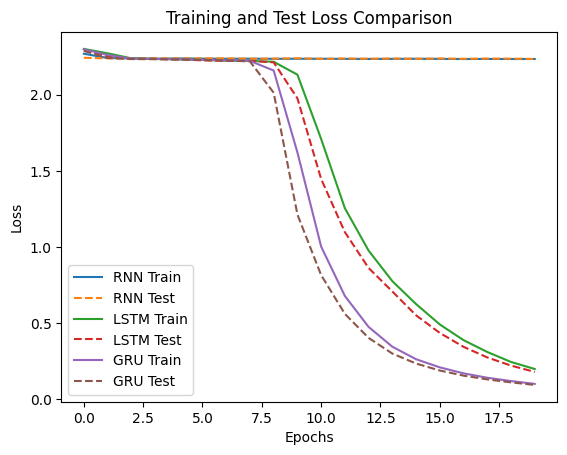

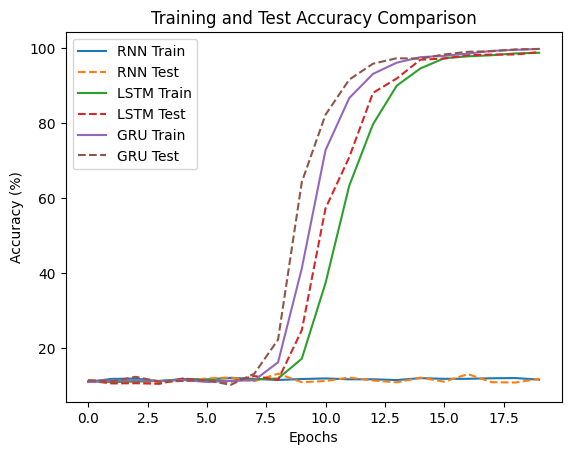

In [9]:
# Исправленная функция для построения графиков
def plot_metrics(train_values, test_values, ylabel, title):
    """
    Построение графиков для сравнения данных метрик (например, потерь и точности)
    train_values: значения метрики для обучения (список списков: [RNN, LSTM, GRU])
    test_values: значения метрики для теста (список списков: [RNN, LSTM, GRU])
    ylabel: подпись для оси Y
    title: заголовок графика
    """
    plt.plot(train_values[0], label="RNN Train")
    plt.plot(test_values[0], '--', label="RNN Test")
    plt.plot(train_values[1], label="LSTM Train")
    plt.plot(test_values[1], '--', label="LSTM Test")
    plt.plot(train_values[2], label="GRU Train")
    plt.plot(test_values[2], '--', label="GRU Test")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Графики потерь
plot_metrics(
    [rnn_train_losses, lstm_train_losses, gru_train_losses],   # Значения потерь для тренировки
    [rnn_test_losses, lstm_test_losses, gru_test_losses],     # Значения потерь для теста
    ylabel="Loss",                                            # Подпись Y (потери)
    title="Training and Test Loss Comparison"                 # Заголовок графика
)

# Графики точности
plot_metrics(
    [rnn_train_accuracies, lstm_train_accuracies, gru_train_accuracies],  # Точности на тренировке
    [rnn_test_accuracies, lstm_test_accuracies, gru_test_accuracies],    # Точности на тесте
    ylabel="Accuracy (%)",                                              # Подпись Y (точность в %)
    title="Training and Test Accuracy Comparison"                       # Заголовок графика
)

## Выводы:
1. Модель RNN В течение первых 20 эпох показывает очень медленное улучшение в обучении. Train Loss снижается очень незначительно, а точность (Train Accuracy) остается на уровне около 11-12%. Это указывает на то, что модель не обучается должным образом, и, возможно, не может извлечь полезные паттерны из данных. Таким образом, модель RNN  не подходит для решения нашей задачи, из-за недостатка способности к запоминанию долгосрочных зависимостей. 

2. Модель LSTM сначала модель показывает низкие результаты, но начиная с 11-й эпохи, потери начинают значительно снижаться, а точность резко возрастает. Это говорит о том, что LSTM способен обучаться на наших данных и извлекать паттерны. Тестовая точность (Test Accuracy) также значительно возрастает, достигая 98.65% к 20-й эпохе. Это указывает на хорошую обобщающую способность модели.
   
3. Модель GRU  постепенно улучшает точность и снижает потери. Модель достигает очень высоких показателей точности, что также говорит о ее способности эффективно обучаться на наших данных. Тестовая точность (Test Accuracy) достигает 99.91%, что является отличным результатом.